# Fit the original and modified Winterwerp (1998) model to data

**Summary:** This worksheet can be used to find the $K_{a}^{'}$ and $K_{b}^{'}$ values in the original and modified floc size models of Winterwerp (1998) and Kuprenas et al. (2018) that produces the closest fit to observed floc size time series.

In [1]:
%pylab inline
%config InlineBackend.figure_format='retina' # hig-res plots for a Retina display

from scipy.integrate import odeint
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


## Define functions

In [2]:
# The W98 ODE to be integrated: dDdt = A-B
def dDdtW98(D, t, Ka, Kb): 
    A = Ka*(Dp**(nf-3)/(nf*rhos))*G*C*D**(4-nf) # aggregation term
    B = Kb*((Dp**(-p))/nf)*(mu/Fy)**q*G**(q+1)*(D-Dp)**p*D**(2*q+1) # breakup term
    dDdt = A-B
    return dDdt

def dDdtW98M(D, t, Ka, Kb): 
    q = c1+c2*D/eta
    A = Ka*(Dp**(nf-3)/(nf*rhos))*G*C*D**(4-nf) # aggregation term
    B = Kb*((Dp**(-p))/nf)*(mu/Fy)**q*G**(q+1)*(D-Dp)**p*D**(2*q+1) # breakup term
    dDdt = A-B
    return dDdt

def W98Meq(De,Ka, Kb,Fy, c2, C, G):
    q = c1+c2*De/sqrt(nu/G)
    return De-(Ka/(Kb*rhos))**(1/(2*q))*(mu/Fy)**(-1/2)*C**(1/(2*q))*G**(-1/2)
    
def density(To,Sppt):
    rho_fresh=1000*(1-(To +288.9414)/(508929.2*(To+68.12963))*(To-3.9863)**2)
    Acoef = 0.824493 - 0.0040899*To + 0.000076438*To**2 -0.00000082467*To**3 + 0.0000000053675*To**4
    Bcoef = -0.005724 + 0.00010227*To - 0.0000016546*To**2
    return rho_fresh + Acoef*Sppt + Bcoef*Sppt**(3/2) + 0.00048314*Sppt**2

def visc(To):
    return 2.7488e-07+1.4907e-06*exp(-0.034812*To)

# print output definition
def output():
    print('Key inputs')
    print('n_f =', around(nf,decimals=2))
    print('Dp [µm] =', around(Dp*10**6, decimals=0))
    print('Df0 [µm] =', around(D0*10**6, decimals=0))
    print('')
    print('Output: equilibrium floc size')
    print('Dfe [µm] =', around(Dfe*10**6,decimals=0))
    print('Dfe calc [µm] =', around(Dfe_calc*10**6,decimals=0))
    print('')
    print('Output: primed coefficients')
    print('Ka-prime =', around(Ka,decimals=4))
    print('Kb-prime =', Kb)
    print('')
    print('Output: composite coefficients')
    print('Ka =',around(Kacomp,decimals=2))
    print('Kb =',around(Kbcomp,decimals=2))
    print('Ka/Kb = ',around(Kacomp/Kbcomp,decimals=2))

    
# print output definition
def output2():
    print('Key inputs')
    print('n_f =', around(nf,decimals=2))
    print('Dp [µm] =', around(Dp*10**6, decimals=0))
    print('Df0 [µm] =', around(D0*10**6, decimals=0))
    print('')
    print('Output: equilibrium floc size')
    print('Dfe [µm] =', around(Dfe*10**6,decimals=0))
    print('')
    print('Output: primed coefficients')
    print('Ka-prime =', around(Ka,decimals=4))
    print('Kb-prime =', Kb)

## Load and plot the floc time series data

In [3]:
# datafile = '03_PS2.csv' # data file to load
datafile ='C50_Prior.csv'
subfolder = 'Data'      # folder within the working directory that contains the data files
df_ps02 = pd.read_csv(subfolder+'/'+datafile) # read in the data file
df_micron = array(df_ps02['D50_micron']) # extract numpy array from the pandas dataframe
t_min = array(df_ps02['Time_min']) # extract numpy array from the pandas dataframe
df_ps02.head() # displays the first few rows of data

,Time_min,D05_micron,D16_micron,D50_micron,D84_micron,D95_micron
0,1,24.730174,31.688492,49.860611,70.235115,90.609771
1,2,26.482963,35.729510,56.754893,76.622373,92.016042
2,3,37.900100,53.385458,58.450317,78.873910,81.274615
3,4,36.539191,49.775534,73.037094,99.650032,120.100630
4,5,45.806390,65.321260,87.271545,112.937132,120.967883


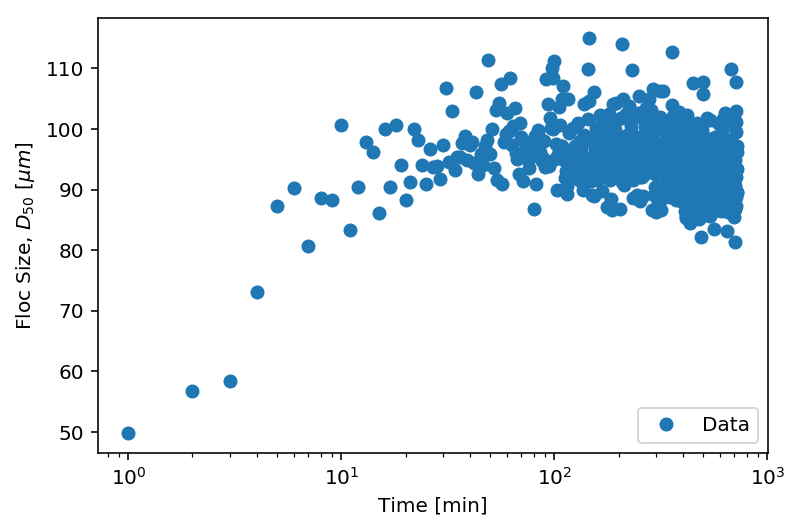

In [4]:
fig, ax = plt.subplots()
ax.plot(t_min,df_micron,'o', label='Data')
ax.set_xscale('log'),
ax.set_xlabel('Time [min]')
ax.set_ylabel('Floc Size, $D_{50}$ [$\mu m$]')
legend(loc=4);

## Fit the models to the data

The cells below will determine the $K_{a}^{'}$ and $K_{b}^{'}$ parameters in the W98 model that produce the closest match between the model and the experimental data given particular fluid, sediment, and floc input properties. This is done by curve fitting the ODE solution to the data. [Note: if you run into run-time problems with the integration, try adjusting the initial guess conditions for $K_{a}^{'}$ and $K_{b}^{'}$, i.e., `Ka0` and `Kb0`] 

### User inputs and initial setup

In [5]:
"""
User input --------------------------------------------------------
"""
# Fluid properties 
G = 50.          # turbulent shear rate[s-1]
To = 20          # temperature in degC
Sppt = 0         # salinity in parts per thousand 

# Sediment properties
C = 50/10**3     # suspended sediment concentration [g/L]
Dp = 5/10**6     # primary particle size [m]
Fy = 1e-10       # floc yeild strength [N]
rhos = 2650.     # sediment density [kg/m3]
nf = 2.0         # fractal dimension

# Calculation inputs 
tstart_min = 1   # minute to start the integration at
D0 = 50/10**6    # floc size at tstart_min [m]

Npts = 10000     # number of points in calculation

# initial guess for fit values (change if there are convergence issues) 
Ka0 = 0.5
Kb0 = 5.0e-6

# coefficients for modification to q
c1 = 0.5
c2 = 2.5
qbase = c1

"""
Setup calculations ----------------------------------------------------
"""
# Pre-integration calcs and array setup
rho = density(To,Sppt)
nu = visc(To)
mu = nu*rho
p = 3.-nf
eta = sqrt(nu/G)

# Setup time array for integration
tend_min = t_min[-1]
t = np.linspace(tstart_min*60,tend_min*60,Npts)

### Fitting the original W98 model with a fixed $q$

Key inputs
n_f = 2.0
Dp [µm] = 5.0
Df0 [µm] = 50.0

Output: equilibrium floc size
Dfe [µm] = 95.0
Dfe calc [µm] = 95.0

Output: primed coefficients
Ka-prime = 0.9835
Kb-prime = 9.167849442527879e-06

Output: composite coefficients
Ka = 37.11
Kb = 2922.42
Ka/Kb =  0.01


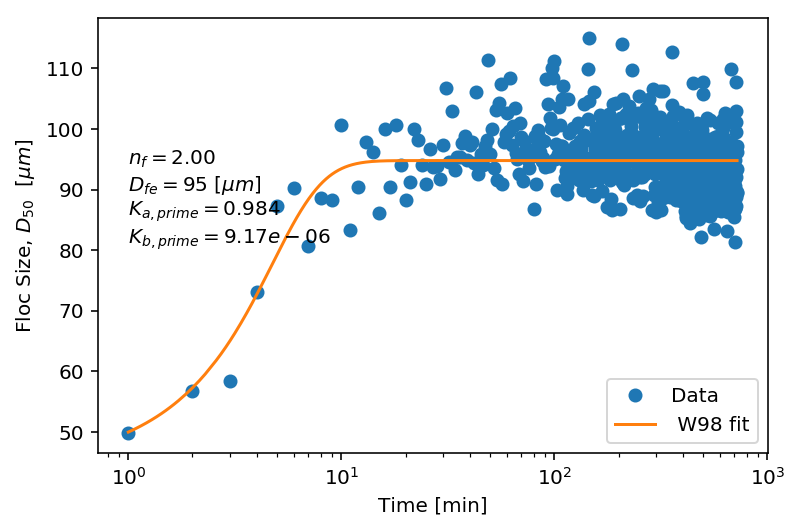

In [6]:
# Pre-integration calcs and array setup
q = qbase

# Setup time array for integration
tend_min = t_min[-1]
t = np.linspace(tstart_min*60,tend_min*60,Npts)

# Solution to the ODE D'(t) = dDdt(D, t, Ka, Kb) with initial condition D(0) = D0
def D(t, Ka0, Kb0): 
    D = odeint(dDdtW98, D0, t, args=(Ka0, Kb0))
    return D.ravel()

# Setup the data for the comparison
df = df_micron/10**6
t_sec = t_min*60

# Curve fit the solution of the ODE to the data
popt, cov = curve_fit(D, t_sec, df, [Ka0,Kb0])

# asign values to the coefficients
Ka, Kb = popt                           # the primed terms in W98
Kacomp = Ka*(Dp**(nf-3)/(nf*rhos))      # unprimed composite aggregation coef
Kbcomp = Kb*((Dp**(-p))/nf)*(mu/Fy)**q  # unprimed composite breakup coef
Dfe_calc = Dp+Kacomp*C/(Kbcomp*sqrt(G))    # equilibrium model floc size in [m]

Dfcalc = D(t, Ka, Kb)
Dfe = Dfcalc[-1]

# Plot and print the results
fig, ax = plt.subplots()
ax.plot(t_min,df_micron,'o', label='Data')
ax.plot(t/60,Dfcalc*10**6, label=' W98 fit')
ax.set_xscale('log'),
ax.set_xlabel('Time [min]')
ax.set_ylabel('Floc Size, $D_{50}$  [$\mu m$]')
legend(loc=4)

results ='$n_f=%.2f$\n$D_{fe}=%.0f$ $[µm]$\n$K_{a,prime}=%.3f$\n$K_{b,prime}=%1.2e$'%(nf,Dfe*10**6,Ka,Kb)
ax.text(t[0]/60,0.85*Dfe*10**6,results)

output();

### Fitting the modified W98 model (Kuprenas et al. 2018) with a varying $q$

/Users/kstrom/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Key inputs
n_f = 2.0
Dp [µm] = 5.0
Df0 [µm] = 50.0

Output: equilibrium floc size
Dfe [µm] = 95.0

Output: primed coefficients
Ka-prime = 0.4024
Kb-prime = 3.0156563646626084e-07


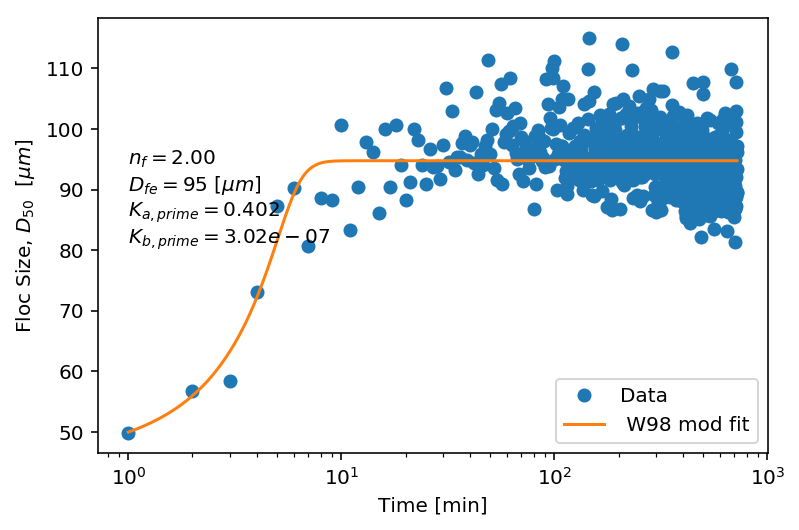

In [7]:
# Solution to the ODE D'(t) = dDdt(D, t, Ka, Kb) with initial condition D(0) = D0
def D(t, Ka0, Kb0): 
    D = odeint(dDdtW98M, D0, t,args=(Ka0, Kb0))
    return D.ravel()

# Setup the data for the comparison
df = df_micron/10**6
t_sec = t_min*60

# Curve fit the solution of the ODE to the data
popt, cov = curve_fit(D, t_sec, df, [Ka0,Kb0])

# asign values to the coefficients
Ka, Kb = popt                           # the primed terms in W98
DfcalcM = D(t, Ka, Kb)               # floc size time series in meters
Kacomp = Ka*(Dp**(nf-3)/(nf*rhos))      # unprimed composite aggregation coef

Dfe = DfcalcM[-1]    # equilibrium model floc size in [m]

# Plot and print the results
fig, ax = plt.subplots()
ax.plot(t_min,df_micron,'o', label='Data')
ax.plot(t/60,DfcalcM*10**6, label=' W98 mod fit')
ax.set_xscale('log'),
ax.set_xlabel('Time [min]')
ax.set_ylabel('Floc Size, $D_{50}$  [$\mu m$]')
legend(loc=4)

results ='$n_f=%.2f$\n$D_{fe}=%.0f$ $[µm]$\n$K_{a,prime}=%.3f$\n$K_{b,prime}=%1.2e$'%(nf,Dfe*10**6,Ka,Kb)
ax.text(t[0]/60,0.85*Dfe*10**6,results)

output2();

### Compare the modeled floc size time series for both the orignial and modified W98

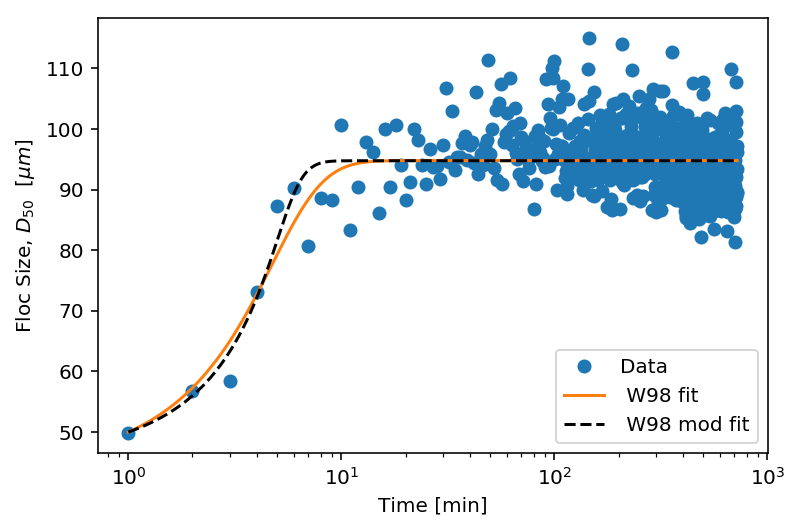

In [8]:
# Plot and print the results
fig, ax = plt.subplots()
ax.plot(t_min,df_micron,'o', label='Data')
ax.plot(t/60,Dfcalc*10**6, label=' W98 fit')
ax.plot(t/60,DfcalcM*10**6,'k--', label=' W98 mod fit')
ax.set_xscale('log'),
ax.set_xlabel('Time [min]')
ax.set_ylabel('Floc Size, $D_{50}$  [$\mu m$]')
legend(loc=4);